In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.size"] = 12

## Numéro 1

The electronic density $n_e$ of a compound of $M$ elements is defined from its density $\rho$ and its composition of atoms of atomic numbers $N_i$ present with massic fractions of $f_i$ such that:
$$
    n_e = \rho\sum_{n=1}^MN_if_i
$$

In [10]:
def electronic_density(density, composition):
    """
    Calculate the electronic density of a compound.
    Params:
    density (float): The density of the compound in g/cm^3.
    composition (dict): A dictionary with the elements' atomic number as keys and the fraction (on 1) by weight of that element as values.
    Returns:
    float: The electronic density of the compound in g/cm^3.
    """
    electronic_density = 0
    for element in composition:
        electronic_density += element * composition[element]
    electronic_density *= density
    return electronic_density

In [11]:
# from NIST for liquid water (https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=276)
liquid_water_density = 1
liquid_water_composition = {1: 0.111894, 8: 0.888106}
liquid_water_ne = electronic_density(liquid_water_density, liquid_water_composition)
print(f"The electronic density of liquid water is {liquid_water_ne:.2f} g/cm^3.")

# from NIST for compact bone (https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=119)
compact_bone_density = 1.85
compact_bone_composition = {1: 0.063984, 6: 0.278000, 7: 0.027000, 8: 0.410016, 12: 0.002000, 15: 0.070000, 16: 0.002000, 20: 0.147000}
compact_bone_ne = electronic_density(compact_bone_density, compact_bone_composition)
print(f"The electronic density of compact bone is {compact_bone_ne:.2f} g/cm^3.")

The electronic density of liquid water is 7.22 g/cm^3.
The electronic density of compact bone is 17.11 g/cm^3.


## Numéro 2

The massic stopping power $S_{col, \rho}$ for a compound is defined like:
$$
\begin{aligned}
    S_{col, \rho} = \frac{S_{col}}{\rho} &= \frac{2\pi r_e^2m_ec^2n_e}{\rho\beta^2}\left[\ln\left(\frac{2m_ec^2(\gamma^2-1)T_e^{max}}{I^2}\right)-2\beta^2\right]\\
    &= \frac{2\pi r_e^2m_ec^2n_e}{\rho\beta^2}\left[\ln\left(\frac{2m_ec^2\beta^2\left(\frac{T}{m_pc^2}+1\right)^2T_e^{max}}{I^2}\right)-2\beta^2\right]\\
\text{where } T_e^{max} \text{ is defined and simplified as:}\\
    T_e^{max} &= \frac{2m_ec^2(\gamma^2-1)}{1+2\gamma\left(\frac{m_e}{m_p}\right)+\left(\frac{m_e}{m_p}\right)^2} = \frac{2m_ec^2\beta^2\left(\frac{T}{m_pc^2}+1\right)^2}{1+2\left(\frac{T}{m_pc^2}+1\right)\left(\frac{m_e}{m_p}\right)+\left(\frac{m_e}{m_p}\right)^2}\\
\text{and } \beta \text{ is found from the cinetic energy } T \text{ like:}\\
    \beta^2 &= \frac{2T}{m_p}
\end{aligned}
$$

In [31]:
def massic_stopping_power(n_e, rho, T, I):
    """
    Calculate the massic stopping power of a material.
    Params:
    n_e (float): The electronic density of the material in g/cm^3.
    Z (float): The atomic number of the material.
    beta (float): The velocity of the incident particle as a fraction of the speed of light.
    rho (float): The density of the material in g/cm^3.
    Returns:
    float: The massic stopping power of the material in MeV/g/cm^2.
    """
    c = 3e10 # speed of light in cm/s 
    r_e = 2.8179e-13 # radius of the electron in cm
    m_e = 0.511 # mass of the electron in MeV/c^2
    m_p = 938.272 # mass of the proton in MeV/c^2
    beta = 2*T / m_p # velocity of the incident particle as a fraction of the speed of light

    T_e_max = 2 * m_e * c**2 * beta**2*((T / (m_p * c**2)) + 1)**2 / (1 + 2 * (T / (m_p * c**2)) + 1 * (m_e / m_p) + (m_e / m_p)**2)
    prefactor = (2 * np.pi * r_e**2 * m_e * c**2 * n_e) / (rho * beta**2)
    log_argument = (2 * m_e * c**2 * beta**2 * ((T / (m_p * c**2)) + 1)**2 * T_e_max) / I**2
    logarithmic_term = np.log(log_argument) - 2 * beta**2
    return prefactor * logarithmic_term

In [36]:
T = np.linspace(3, 250, 1000) # array of kinetic energies of the incident particle in MeV

liquid_water_I = 75 # ionization energy of liquid water in eV

massic_stopping_power_water = massic_stopping_power(liquid_water_ne, liquid_water_density, T, liquid_water_I)

compact_bone_I = 91.9 # ionization energy of compact bone in eV

massic_stopping_power_bone = massic_stopping_power(compact_bone_ne, compact_bone_density, T, compact_bone_I)

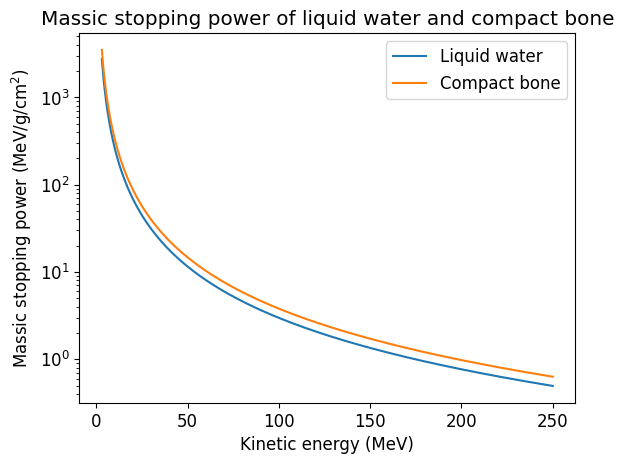

In [35]:
plt.plot(T, massic_stopping_power_water, label="Liquid water")  
plt.plot(T, massic_stopping_power_bone, label="Compact bone")
plt.yscale("log")
plt.xlabel("Kinetic energy (MeV)")
plt.ylabel(r"Massic stopping power (MeV/g/cm$^2$)")
plt.legend()
plt.title("Massic stopping power of liquid water and compact bone")
plt.show()

## Numéro 3

Lorsqu’un proton entre en collision avec la matière, deux principaux phénomènes entraînent sa décélération. Ces phénomènes sont les interactions nucléaires et les interactions radiatives.Les interactions nucléaires correspondent aux interactions entre les protons incidents et les noyaux présents dans la matière. Quant aux interactions radiatives, elles se produisent entre les protons incidents et les électrons du milieu.

Le NIST fournit une base de données identifiant l’ampleur de ces interactions individuelles. Voici ces interactions représentées dans un même graphique.

In [49]:
def read_pstar_data(filename):
    """
    Reads a text file and saves the data into a NumPy array.
    
    Parameters:
        filename (str): Path to the text file.
    
    Returns:
        np.ndarray: NumPy array containing the data.
    """
    try:
        data = np.loadtxt(filename, delimiter=",", dtype=float, skiprows=8, usecols=(0, 1, 2, 3, 4, 5))
        return data
    except Exception as e:
        print(f"Error reading file: {e}")
        return None
    
class Medium:
    def __init__(self, data):
        self.data = data
        self.nuclear_stoping_power = self.get_nucleare_stoping_power()
        self.electronic_stoping_power = self.get_electronic_stoping_power()

    def get_electronic_stoping_power(self):
        return np.column_stack((self.data[:, 0], self.data[:, 1]))
    
    
    def get_nucleare_stoping_power(self):
        return np.column_stack((self.data[:, 0], self.data[:, 2]))
    
    def graph_all_stoping_power(self):
        plt.plot(self.nuclear_stoping_power[:,0], self.nuclear_stoping_power[:,1], label="Nuclear stopping power")
        plt.plot(self.electronic_stoping_power[:,0], self.electronic_stoping_power[:,1], label="Electronic stopping power")
        plt.xlabel("Energy (MeV)")
        plt.ylabel("Stopping power (MeV cm^2/g)")
        plt.legend()
        plt.show()
        

[[3.000e+00 7.972e-02]
 [6.000e+00 4.195e-02]
 [9.000e+00 2.873e-02]
 [1.200e+01 2.194e-02]
 [1.500e+01 1.778e-02]
 [1.800e+01 1.497e-02]
 [2.100e+01 1.295e-02]
 [2.400e+01 1.141e-02]
 [2.700e+01 1.021e-02]
 [3.000e+01 9.239e-03]
 [3.300e+01 8.441e-03]
 [3.600e+01 7.773e-03]
 [3.900e+01 7.205e-03]
 [4.200e+01 6.716e-03]
 [4.500e+01 6.290e-03]
 [4.800e+01 5.916e-03]
 [5.100e+01 5.585e-03]
 [5.400e+01 5.290e-03]
 [5.700e+01 5.025e-03]
 [6.000e+01 4.786e-03]
 [6.300e+01 4.569e-03]
 [6.600e+01 4.372e-03]
 [6.900e+01 4.191e-03]
 [7.200e+01 4.024e-03]
 [7.500e+01 3.871e-03]
 [7.800e+01 3.729e-03]
 [8.100e+01 3.598e-03]
 [8.400e+01 3.476e-03]
 [8.700e+01 3.361e-03]
 [9.000e+01 3.255e-03]
 [9.300e+01 3.155e-03]
 [9.600e+01 3.061e-03]
 [9.900e+01 2.973e-03]
 [1.020e+02 2.889e-03]
 [1.050e+02 2.811e-03]
 [1.080e+02 2.736e-03]
 [1.110e+02 2.666e-03]
 [1.140e+02 2.599e-03]
 [1.170e+02 2.536e-03]
 [1.200e+02 2.475e-03]
 [1.230e+02 2.418e-03]
 [1.260e+02 2.363e-03]
 [1.290e+02 2.311e-03]
 [1.320e+02

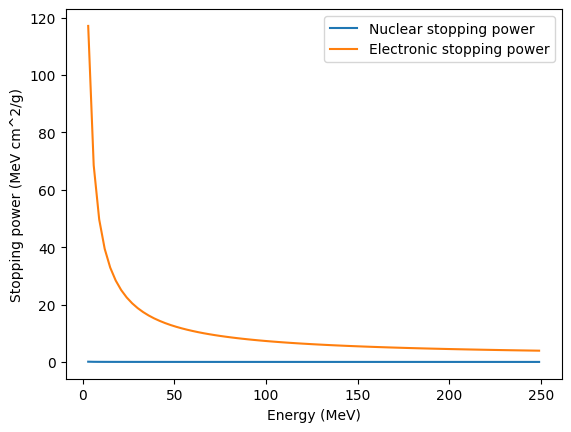

In [50]:
water = Medium(read_pstar_data("/Users/laurentemond/Desktop/PhysNum/tp_phys_num/tp1/waterLiquidStoppingPower.txt"))
water.graph_all_stoping_power()

## Numéro 4

Plus le pouvoir d'arrêt d'un matériel est grand, plus la portée de la particule sera faible dans le matériel. Il est donc logique et intuitif de dire que la portée suit une tendance inverse au pouvoir d'arrêt. 

Il est également possible de démontrer cela en utilisant les unités. Nous cherchons une portée (unités: cm, dimension: $L$) à partir du pouvoir d'arrêt (unités: MeV/cm, dimensions: $ML/T^2$) et de l'énergie (unités: MeV, dimensions: $ML^2/T^2$). Notre seul moyen d'obtenir la dimension adéquate pour la portée est de multiplier les dimensions de l'énergie par les dimensions de l'inverse du pouvoir d'arrêt : $ML^2/T^2 \cdot (ML/T^2)^{-1} = L$.

C'est exactement ce que nous retrouvons pour la formule de la portée CSDA: $R_{CSDA} = \int_0^{T_i} \frac{1}{S} dT$

## Numéro 5

La formule pour le pouvoir d'arrêt est relativement complexe, et nous retrouvons avec une intégrale de forme $\int \frac{1}{ln(T)+B} dT$, où B est une constante. Cette intégrale ne produit pas de solution analytique, et donc l'utilisation d'une méthode analytique est nécessaire.  

## Numéro 6

## Numéro 7

## Numéro 8

## Numéro 9

## Numéro 10

## Numéro 11

## Numéro 12

## Numéro 13

## Numéro 14

## Numéro 15

## Numéro 16

## Numéro 17